## WGAN-GP
The Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) is an advanced type of GAN that addresses some common issues found in traditional GANs, such as training instability and mode collapse. By using the Wasserstein distance as the loss function and adding a gradient penalty, WGAN-GP provides smoother and more reliable training dynamics.

Key Features of WGAN-GP:

**Wasserstein Loss Function:** Instead of the standard loss, WGAN uses the Wasserstein distance (also known as Earth Mover's Distance) which provides meaningful gradients even when the generator and real data distributions do not overlap.

**Gradient Penalty:** To enforce the Lipschitz constraint required by the Wasserstein distance, WGAN-GP adds a gradient penalty to the loss function of the critic (discriminator). This replaces weight clipping and leads to better performance.

**Improved Stability:** These changes result in a more stable training process, making it easier to train the GAN and achieve higher-quality generated images.

In this Colab notebook, we'll train a WGAN-GP on the CIFAR-10 dataset to generate images of automobiles. We'll monitor the training progress using metrics like the Fréchet Inception Distance (FID) and Inception Score (IS), and visualize the generated images to assess the quality of the model.

**Why Use WGAN-GP?**

**Better Gradient Flow:** Helps the generator receive more informative updates.
Stability: Reduces issues like mode collapse, where the generator produces limited varieties of images.
**Quality of Outputs:** Tends to produce more realistic and diverse images compared to traditional GANs.
Let's dive into the implementation and see how WGAN-GP enhances the generative modeling of images!

In [1]:
pip install tensorflow numpy keras

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar vxzf cifar-10-python.tar.gz

--2024-09-15 09:26:34--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.1MB/s    in 3.9s    

2024-09-15 09:26:38 (41.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [6]:
import pickle
import numpy as np
import tensorflow as tf

def load_data(size:int):
   def load_cifar_batch(file:str):
      with open(file, 'rb') as fo:
         dict = pickle.load(fo, encoding='bytes')
      return dict

   x_train, labels = [], []
   for i in range(1, size+1):
      file_path = f"cifar-10-batches-py/data_batch_{i}"
      label = load_cifar_batch(file_path)[b'labels']
      imgs = load_cifar_batch(file_path)[b'data']
      x_train.append(imgs)
      labels.append(label)
   # images
   x_train = np.concatenate(x_train, axis=0)
   x_train = np.reshape(x_train, (len(x_train), 3, 32, 32)).astype('float32')
   x_train = np.transpose(x_train, (0, 2, 3, 1))
   # labels
   labels = np.concatenate(labels, axis=0)
   labels = tf.one_hot(labels, 10)
   return x_train, labels


def augment_image(image, label):
   image = tf.image.random_flip_left_right(image)
   image = tf.image.random_brightness(image, 0.1)
   image = tf.image.random_contrast(image, 0.9, 1.1)
   image = tf.image.random_hue(image, 0.1)
   return image, label


def apply_augmentation(image, label):
   augmented_image, augmented_label = tf.cond(
      tf.random.uniform(()) < 0.6,
      lambda: augment_image(image, label),
      lambda: (image, label)
   )
   augmented_image = (augmented_image / 255 - 0.5) * 2
   augmented_image = tf.clip_by_value(augmented_image, -1, 1)
   return augmented_image, augmented_label


def load_dataset(data_size, batch_size, augmentations=True):
   x_train, y_train = load_data(data_size)
   dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(data_size*10000)
   if augmentations:
      dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
   dataset = dataset.batch(batch_size, drop_remainder=True)
   return dataset

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from numpy import cov, trace, iscomplexobj
import numpy as np
from scipy.stats import entropy

def preprocess_and_resize(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

def calculate_fid(real_images, generated_images, model):
    # Resize and preprocess images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    real_images_preprocessed = preprocess_input(real_images_resized)
    generated_images_preprocessed = preprocess_input(generated_images_resized)

    # Extract features using InceptionV3
    real_features = model.predict(real_images_preprocessed)
    generated_features = model.predict(generated_images_preprocessed)

    # Calculate mean and covariance of features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))

    if iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

def calculate_inception_score(predictions, splits=10):
    scores = []
    n = len(predictions)
    split_size = n // splits
    for i in range(splits):
        part = predictions[i * split_size: (i + 1) * split_size]
        p_y = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(p, p_y) for p in part])))

    return np.mean(scores), np.std(scores)


In [12]:
import os, time, cv2, datetime
import tensorflow as tf
import numpy as np
from tensorflow import summary
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Flatten, Concatenate
from tensorflow.keras.models import Model


class WGAN_GP(Model):
   def __init__(self, generator, critic, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.generator = generator
      self.critic = critic


   def compile(self,
               g_opt,
               c_opt,
               lat_dim:int,
               lambda_gp:int,
               critic_steps:int,
               epoch_img:int,
               epoch_checkpoint:int,
               *args, **kwargs):
      super().compile(*args, **kwargs)
      self.g_opt = g_opt
      self.c_opt = c_opt
      self.lat_dim = lat_dim
      self.lambda_gp = lambda_gp
      self.critic_steps = critic_steps
      self.epoch_img = epoch_img
      self.epoch_checkpoint = epoch_checkpoint
      self.fid_scores = []
      self.is_scores = []
      # checkpoint settings
      self.checkpoint_dir = './checkpoints'
      self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
      self.checkpoint = tf.train.Checkpoint(g_opt=self.g_opt,
                                            c_opt=self.c_opt,
                                            generator=self.generator,
                                            critic=self.critic)



   def get_generator(self):
      return self.generator

   def get_fid_scores(self):
      return self.fid_scores


   def get_is_scores(self):
      return self.is_scores

   def critic_loss(self, real_images, fake_images, fake_output, real_output, labels):
      alpha = tf.random.uniform([real_images.shape[0], 1, 1, 1], minval=0.0, maxval=1.0)
      interpolated_images = alpha * real_images + (1 - alpha) * fake_images

      with tf.GradientTape() as gp_tape:
         gp_tape.watch(interpolated_images)
         interpolated_output = self.critic([interpolated_images, labels], training=True)

      gradients = gp_tape.gradient(interpolated_output, interpolated_images)
      gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
      gradient_penalty = tf.reduce_mean(tf.square(gradients_norm - 1))

      gp = self.lambda_gp * gradient_penalty
      loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output) + gp
      return loss, gp


   def generator_loss(self, fake_output):
      return -tf.reduce_mean(fake_output)


   @tf.function
   def train_step(self, real_images:tf.Tensor, labels:tf.Tensor) -> dict:
      noise = tf.random.normal((real_images.shape[0], self.lat_dim))
      with tf.GradientTape() as c_tape, tf.GradientTape() as g_tape:
         fake_images = self.generator([noise, labels], training=True)

         real_output = self.critic([real_images, labels], training=True)
         fake_output = self.critic([fake_images, labels], training=True)

         c_loss, gp = self.critic_loss(real_images, fake_images, fake_output, real_output, labels)
         g_loss = self.generator_loss(fake_output)

      # calculate grads
      cgrad = c_tape.gradient(c_loss, self.critic.trainable_variables)
      ggrad = g_tape.gradient(g_loss, self.generator.trainable_variables)
      # update models
      self.c_opt.apply_gradients(zip(cgrad, self.critic.trainable_variables))
      self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

      real_out = tf.reduce_mean(real_output)
      return  {"c_loss": c_loss, "g_loss": g_loss, "real_out": real_out, "GP": gp}


   @tf.function
   def train_step_discriminator(self, real_images:tf.Tensor, labels:tf.Tensor) -> dict:
      noise = tf.random.normal((real_images.shape[0], self.lat_dim))
      with tf.GradientTape() as c_tape:
         fake_images = self.generator([noise, labels], training=True)

         real_output = self.critic([real_images, labels], training=True)
         fake_output = self.critic([fake_images, labels], training=True)

         c_loss, gp = self.critic_loss(real_images, fake_images, fake_output, real_output, labels)
         g_loss = self.generator_loss(fake_output)

      # update critic
      cgrad = c_tape.gradient(c_loss, self.critic.trainable_variables)
      self.c_opt.apply_gradients(zip(cgrad, self.critic.trainable_variables))

      real_out = tf.reduce_mean(real_output)
      return  {"c_loss": c_loss, "g_loss": g_loss, "real_out": real_out, "GP": gp}


   def train(self, dataset, data_size:int, batch_size=32, epochs=10) -> dict:
      logdir = f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/"
      summary_writer = summary.create_file_writer(logdir)
      n_batches = data_size//batch_size-1
      k = 33 # lenght of loading bar
      inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
      inception_model_with_top = InceptionV3(include_top=True, weights='imagenet')

      for epoch in range(1, epochs+1):
         print(f"Epoch: {epoch}/{epochs}")
         mean_batch_time = 0
         ds = iter(dataset)

         for step in range(n_batches):
            time_step = time.time()
            batch_images, batch_labels = next(ds)

            # Train Step
            if step%self.critic_steps==0:
               params_dict = self.train_step(batch_images, batch_labels)
            else:
               params_dict = self.train_step_discriminator(batch_images, batch_labels)

            # Create logs dict for batch and epoch
            if step == 0:
               batch_logs = {key:0 for key in params_dict.keys()}
            if epoch == 1:
               hist = {key:[] for key in params_dict.keys()}

            # Dynamic print
            alpha = 1/(step+1) if step>0 else 0
            info = ""
            for key, val in params_dict.items():
               batch_logs[key] = (1-alpha)*batch_logs[key] + alpha*val
               info += f" - {key}: {batch_logs[key]:.3f}"

            # Calculate time, loading bar length and display info
            mean_batch_time = (1-alpha)*mean_batch_time + alpha*(time.time() - time_step)
            time_to_end = mean_batch_time * (n_batches - step)
            m = int((step+1)/(n_batches/k))+1
            bar = f"[{'='*m}{'-'*(33-m)}]"
            print(f"Batch: {step+1}/{n_batches}  {bar}  {time_to_end:.1f}s{info}{' '*6}", end='\r')

         epoch_time = mean_batch_time * (step+1)
         fixed_noise = tf.random.normal((batch_images.shape[0], self.lat_dim))


         print(f"Batch: {n_batches}/{n_batches}  {bar}  {epoch_time:.1f}s{info}{' '*6}")


         # Learning rate decrease
         if epoch%2==0:
            # generator
            lr = self.g_opt.learning_rate.numpy() * 0.995
            self.g_opt.learning_rate.assign(lr)
            # discriminator
            lr = self.c_opt.learning_rate.numpy() * 0.995
            self.c_opt.learning_rate.assign(lr)

         # Save Checkpoint
         if (epoch) % self.epoch_checkpoint == 0 and epoch > 1:
               self.checkpoint.save(file_prefix=self.checkpoint_prefix)
               fake_images = self.generator([fixed_noise, batch_labels], training=True)
               fid_score = calculate_fid(batch_images, fake_images, inception_model)
               self.fid_scores.append([epoch, fid_score])
               preds = inception_model_with_top.predict(preprocess_and_resize(fake_images))
               is_score, is_std = calculate_inception_score(preds)
               self.is_scores.append([epoch, is_score, is_std])
               print(f'Epoch {epoch}, Batch {n_batches}, FID: {fid_score} is score {is_score}')
         # Save Images
         if (epoch) % self.epoch_img == 0 or epoch == 1:
            images_grid = self.sample_img(epoch, save=True)
         else:
            images_grid = self.sample_img(epoch)
         # Save logs
         for key, val in batch_logs.items():
            hist[key].append(val)

         with summary_writer.as_default():
            summary.image(f"generator_output", images_grid, step=epoch)
            summary.scalar(f"learning_rate/generator", self.g_opt.learning_rate.numpy(), step=epoch)
            summary.scalar(f"learning_rate/critic", self.c_opt.learning_rate.numpy(), step=epoch)
            for key in hist:
               summary.scalar(f"metrics/{key}", hist[key][-1], step=epoch)

      return hist


   def sample_img(self, epoch:int, save=False) -> None:
      rows, cols = 10, 10
      if not hasattr(self, 'sample_noise'):
         self.sample_noise = tf.random.normal((rows*cols, self.lat_dim))
         labels = np.repeat(np.arange(10), rows)
         self.labels_onehot = tf.one_hot(labels, 10)
      images = self.generator([self.sample_noise, self.labels_onehot], training=False)
      images = (0.5 * images + 0.5) * 255
      image_size = (32, 32)
      grid_image = np.zeros((cols*image_size[0], rows*image_size[1], 3), dtype=np.uint8)

      idx = 0
      for i in range(cols):
         for j in range(rows):
            if idx < len(images):
                  image = images[idx]
                  grid_image[i*image_size[0]:(i+1)*image_size[0], j*image_size[1]:(j+1)*image_size[1], :] = image
                  idx += 1
      if save:
         grid_bgr = cv2.cvtColor(grid_image, cv2.COLOR_RGB2BGR)
         cv2.imwrite(f"images/epo_{epoch}.png", grid_bgr)
      return tf.expand_dims(grid_image, axis=0)


   def restore_checkpoint(self):
      self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir))


### Critic ###
def conv2D_block(x, filters, kernel_size=5, strides=2, padding='same'):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding=padding,
              kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
   x = LeakyReLU(alpha=0.2)(x)
   return x


def build_critic(image_size=(32,32,3), num_classes=10):
   images = Input(shape=image_size)
   labels = Input(shape=(num_classes,))

   x = conv2D_block(images, 64)
   x = conv2D_block(x, 128)
   x = conv2D_block(x, 196)
   x = conv2D_block(x, 324)

   x = Flatten()(x)
   x = Concatenate()([x, labels])
   x = Dense(256)(x)
   x = LeakyReLU(alpha=0.2)(x)

   validity = Dense(1)(x)

   model = Model(inputs=[images, labels], outputs=validity, name='critic')
   return model


### Generator ###
def conv2DT_block(x, filters, kernel_size=5, strides=2, padding='same'):
   x = Conv2DTranspose(filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding=padding,
                       use_bias=False,
                       kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x)
   return x


def build_generator(latent_dim, num_classes=10):
   z = Input(shape=(latent_dim,))
   labels = Input(shape=(num_classes,))

   x = Concatenate()([z, labels])

   x = Dense(2*2*512, use_bias=False)(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x)

   x = Reshape((2, 2, 512))(x)
   x = conv2DT_block(x, 256)
   x = conv2DT_block(x, 128)
   x = conv2DT_block(x, 64)

   image = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

   model = Model(inputs=[z, labels], outputs=image, name='generator')
   return model



In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

for gpu in tf.config.list_physical_devices('GPU'):
   print(gpu)
   tf.config.experimental.set_memory_growth(gpu, True)

###  settings  ###
data_size = 5 # times 10k, max 6 - 60k

generator_lr = 5e-4
critic_lr = 2e-4
beta_1 = 0.5
beta_2 = 0.999

batch_size = 128
lat_dim = 128
lambda_gp = 10 # gradient penalty coefficient
disc_steps = 5 # critic train steps every 1 generator train step

epochs = 1000

image_on_epoch = 1  # Save sample images every {epoch_img} epochs
checkpoint_on_epoch = 25 # Save checkpoint every {epoch_checkpoint} epochs
restore_last_checkpoint = False
### end-settings  ###


# Create cWGAN_GP
generator = build_generator(lat_dim)
critic = build_critic()
generator.summary()
critic.summary()


g_opt = Adam(generator_lr, beta_1=beta_1, beta_2=beta_2)
c_opt = Adam(critic_lr, beta_1=beta_1, beta_2=beta_2)

gan = WGAN_GP(generator, critic)
gan.compile(g_opt=g_opt,
            c_opt=c_opt,
            lat_dim=lat_dim,
            lambda_gp=lambda_gp,
            critic_steps=disc_steps,
            epoch_img=image_on_epoch,
            epoch_checkpoint=checkpoint_on_epoch)

if restore_last_checkpoint:
   gan.restore_checkpoint()

# load dataset
dataset = load_dataset(data_size, batch_size)

# start training
gan.train(dataset, data_size=data_size*10000, epochs=epochs, batch_size=batch_size)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_12 (Concatenat  (None, 138)                  0         ['input_13[0][0]',            
 e)                                                                  'input_14[0][0]']            
                                                                                                  
 dense_6 (Dense)         

KeyboardInterrupt: 

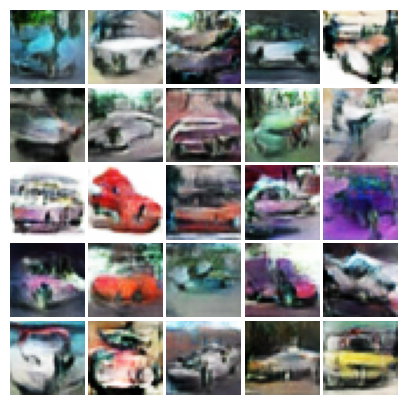

In [50]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming the GAN has been trained and we have access to the generator
# Get the generator from the trained WGAN_GP model
generator = gan.get_generator()
lat_dim = gan.lat_dim  # Get the latent dimension used during training

# Generate 25 random latent vectors
num_images = 25
noise = tf.random.normal([num_images, lat_dim])

# Create labels for 'automobile', which is class 1 in CIFAR-10
automobile_label = 1
labels = np.full(shape=(num_images,), fill_value=automobile_label)
labels_onehot = tf.one_hot(labels, depth=10)

# Generate images
generated_images = generator([noise, labels_onehot], training=False)

# Post-process images
generated_images = (generated_images + 1) / 2.0  # Rescale images from [-1,1] to [0,1]
generated_images = generated_images.numpy()

# Display images in grid
grid_size = (5, 5)  # 5x5 grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))

# Adjust the spacing between subplots to make the grid compact
plt.subplots_adjust(wspace=0.05, hspace=0.05)

axes = axes.flatten()
for img, ax in zip(generated_images, axes):
    # Remove any padding around the images
    ax.imshow(img)
    ax.axis('off')
plt.show()


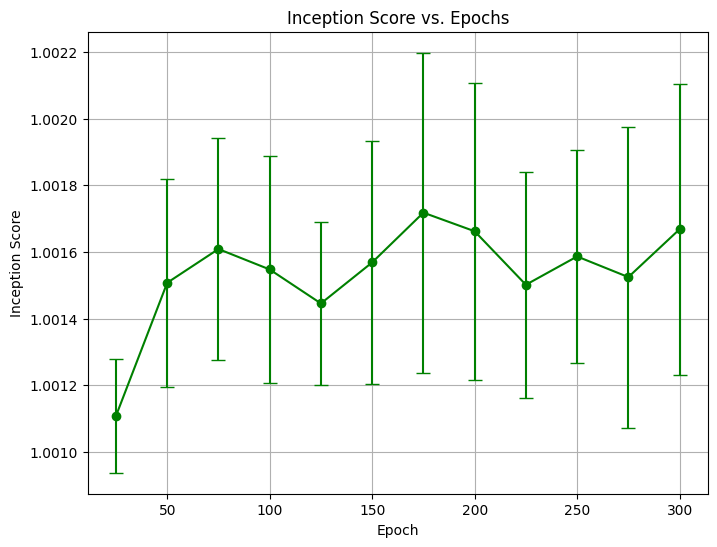

In [43]:
import matplotlib.pyplot as plt

# Assuming your trained GAN model instance is named 'gan'

# Retrieve the FID and IS scores from the model
fid_scores = gan.get_fid_scores()  # Returns a list of [epoch, fid_score]
is_scores = gan.get_is_scores()    # Returns a list of [epoch, is_score, is_std]

# Check if scores are available
if is_scores:

    # Separate epochs and scores for IS
    epochs_is = [item[0] for item in is_scores]
    is_values = [item[1] for item in is_scores]
    is_std = [item[2] for item in is_scores]


    # Plot Inception Scores with error bars
    plt.figure(figsize=(8, 6))
    plt.errorbar(epochs_is, is_values, yerr=is_std, fmt='o-', capsize=5, color='green')
    plt.title('Inception Score vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Inception Score')
    plt.grid(True)
    plt.show()


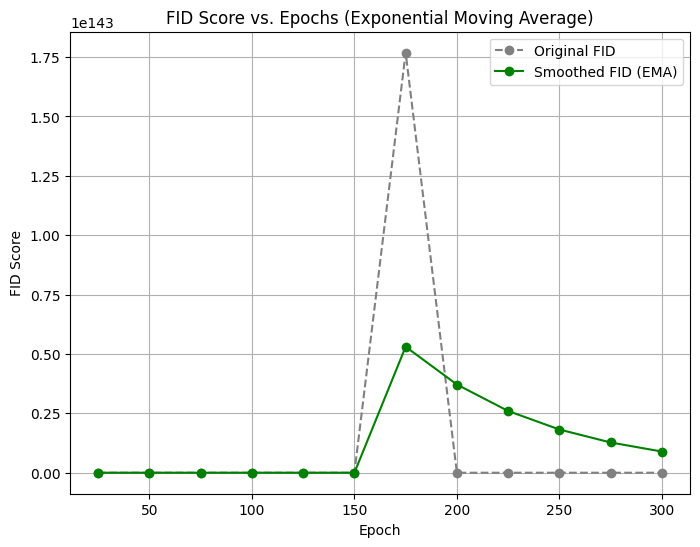

In [45]:
def exponential_moving_average(data, alpha=0.3):
    ema = [data[0]]  # Start with the first data point
    for point in data[1:]:
        ema.append(alpha * point + (1 - alpha) * ema[-1])
    return np.array(ema)

# Apply EMA smoothing
alpha = 0.3  # Smoothing factor between 0 and 1
ema_fid = exponential_moving_average(fid_values, alpha)

# Plot original and smoothed FID scores
plt.figure(figsize=(8, 6))
plt.plot(epochs_fid, fid_values, marker='o', linestyle='--', color='gray', label='Original FID')
plt.plot(epochs_fid, ema_fid, marker='o', linestyle='-', color='green', label='Smoothed FID (EMA)')
plt.title('FID Score vs. Epochs (Exponential Moving Average)')
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.legend()
plt.grid(True)
plt.show()


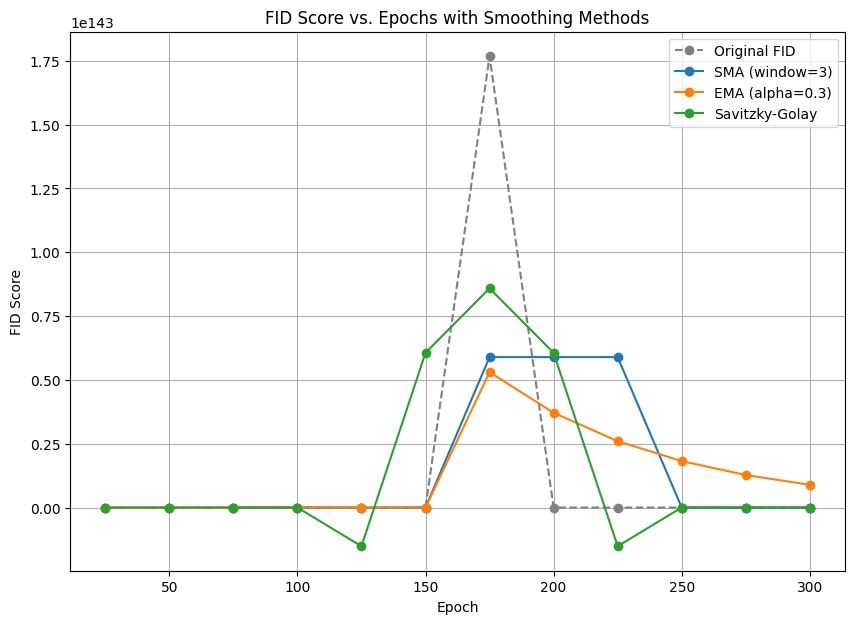

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Ensure fid_scores is not empty
if fid_scores:
    epochs_fid = np.array([item[0] for item in fid_scores])
    fid_values = np.array([item[1] for item in fid_scores])

    # SMA
    window_size = 3
    if len(fid_values) >= window_size:
        sma_fid = np.convolve(fid_values, np.ones(window_size)/window_size, mode='valid')
        sma_epochs = epochs_fid[window_size - 1:]
    else:
        sma_fid = fid_values
        sma_epochs = epochs_fid

    # EMA
    alpha = 0.3
    ema_fid = exponential_moving_average(fid_values, alpha)

    # Savitzky-Golay
    window_length = 5  # Must be odd
    polyorder = 2
    if len(fid_values) >= window_length:
        sg_fid = savgol_filter(fid_values, window_length, polyorder)
    else:
        sg_fid = fid_values

    # Plot all together
    plt.figure(figsize=(10, 7))
    plt.plot(epochs_fid, fid_values, marker='o', linestyle='--', color='gray', label='Original FID')
    plt.plot(sma_epochs, sma_fid, marker='o', linestyle='-', label='SMA (window=3)')
    plt.plot(epochs_fid, ema_fid, marker='o', linestyle='-', label='EMA (alpha=0.3)')
    plt.plot(epochs_fid, sg_fid, marker='o', linestyle='-', label='Savitzky-Golay')
    plt.title('FID Score vs. Epochs with Smoothing Methods')
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No FID scores available to plot.")


## Conclusion

Training a Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) for image generation, particularly on datasets like CIFAR-10, is a nuanced process that requires careful consideration of model architecture, hyperparameters, and evaluation metrics. The WGAN-GP framework addresses some of the inherent challenges in training traditional GANs, such as mode collapse and training instability, by providing a more stable and theoretically sound approach to optimizing the generator and critic (discriminator) networks.

Key Takeaways:

**Stability and Convergence:**

Wasserstein Loss: The use of the Wasserstein distance as the loss function provides smoother gradients and a meaningful measure of distance between the real and generated data distributions. This leads to more stable training compared to the traditional Jensen-Shannon divergence used in vanilla GANs.
Gradient Penalty: Implementing the gradient penalty ensures that the critic satisfies the Lipschitz continuity condition, which is crucial for the Wasserstein distance to be valid. This technique replaces weight clipping and allows for more expressive critic models.


**Model Architecture:**

Generator and Critic Design: Both networks were carefully designed with convolutional layers suitable for image data. Techniques like batch normalization and Leaky ReLU activations help in stabilizing training and improving convergence.
Conditional GAN Setup: Incorporating labels through concatenation enables the model to generate images conditioned on specific classes, allowing for more controlled and meaningful outputs (e.g., generating images of automobiles specifically).

**Hyperparameter Tuning:**

Learning Rates and Optimizers: Different learning rates for the generator and critic (e.g., generator_lr = 5e-4, critic_lr = 2e-4) and the use of the Adam optimizer with appropriate beta values help in balancing the training dynamics between the two networks.

**Gradient Penalty Coefficient (lambda_gp):** Setting lambda_gp = 10 is standard, but tuning this parameter can affect the enforcement of the Lipschitz constraint and, consequently, the quality of generated images.
Critic Steps (disc_steps): Training the critic multiple times per generator update (e.g., disc_steps = 5) allows the critic to better estimate the Wasserstein distance, leading to improved generator updates.
Monitoring and Evaluation:

**FID and Inception Scores:** Calculating the Fréchet Inception Distance (FID) and Inception Score (IS) at regular intervals provides quantitative measures of the generator's performance in terms of image quality and diversity. Plotting these scores against epochs helps in visualizing the training progress and detecting issues like mode collapse or overfitting.

As we saw in the diagram the FID and IS scores were fluctuating a bit. I have stopped training after 300 iterations due to limited hardware and GPU availability. Training can be further continued to gain more accuracy and improve FID and IS Scores.


**Training Time: **Training WGAN-GP models can be computationally intensive and time-consuming, especially with higher-resolution images or larger datasets.
It took around 1 hr to train 300 epochs with A100 GPU. This can be cost intensive process.

**Hyperparameter Sensitivity:** GANs are sensitive to hyperparameters, and finding the optimal settings often requires experimentation and domain knowledge.
Mode Collapse: While WGAN-GP reduces the likelihood of mode collapse compared to vanilla GANs, it can still occur. Monitoring diversity in generated samples is essential.


Practical Insights:

**Data Augmentation: **Applying data augmentation techniques helps in increasing the diversity of the training data, which can improve the generalization of the generator.
Checkpointing and Logging: Saving model checkpoints and logging training metrics facilitates resuming training and analyzing past performance.
Visualization Tools: Utilizing tools like TensorBoard for logging images and metrics enhances the ability to monitor training in real-time.
Final Thoughts:

Training a WGAN-GP model is a balancing act that requires attention to the interplay between the generator and critic networks. The improvements offered by the Wasserstein framework and gradient penalty contribute to more stable and reliable training, but they do not eliminate the need for careful tuning and monitoring.

By systematically adjusting hyperparameters, employing robust evaluation metrics, and closely observing both quantitative and qualitative outputs, one can successfully train a WGAN-GP to generate high-quality, diverse images. The process underscores the importance of combining theoretical advancements with practical machine learning practices to achieve desirable results in generative modeling.

# Future Directions:

**Experimentation with Architectures:** Exploring advanced architectures like ResNet blocks or attention mechanisms could further enhance the quality of generated images.


**Larger and Diverse Datasets:** Training on larger datasets or higher-resolution images can push the boundaries of the model's capabilities.
Conditional Generation Enhancements: Incorporating more sophisticated conditioning methods, such as embedding labels or using class-specific normalization layers, may improve the control over generated outputs.
Hyperparameter Optimization: Leveraging automated hyperparameter tuning tools or techniques like Bayesian optimization can streamline the search for optimal settings.


 **Conclusion:**

The journey of training a WGAN-GP involves both challenges and rewards. The model's ability to generate convincing images of automobiles demonstrates the potential of GANs in creative and practical applications. With continued refinement and exploration, WGAN-GP models can serve as powerful tools in the field of generative modeling and beyond.